# 以螢幕畫面的所有像素為狀態值，採用Deep Q-Learning演算法求解木棒台車

## 載入套件

In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque
from PIL import Image
import torch.nn.functional as F
import torchvision.transforms as T

## 載入木棒台車遊戲

In [2]:
env = gym.make("CartPole-v1", render_mode='rgb_array')

## 畫面轉換測試

In [3]:
state, info = env.reset()
img = Image.fromarray(env.render())
img.show()

In [4]:
env.render().shape

(400, 600, 3)

In [5]:
env.render().transpose(2, 0, 1).shape

(3, 400, 600)

In [6]:
transforms = T.Compose([T.ToPILImage(),
                T.Resize(60),
                T.Grayscale(),
                ])
img = transforms(env.render())
# print(data.shape)
# img = Image.fromarray(data, 'L') #.squeeze().numpy())
img.show()
np.array(img).shape

(60, 90)

In [7]:
# not work for T.ToTensor transformation
# transforms = T.Compose([T.ToPILImage(),
#                 T.Resize(60),
#                 T.Grayscale(),
#                 T.ToTensor()])
# data = transforms(env.render())
# data = data.reshape(*data.shape[1:])
# print(data.shape)
# img = Image.fromarray(data.numpy())
# img.show()

## 定義神經網路模型

In [8]:
# ---- CONVOLUTIONAL NEURAL NETWORK ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
nn_inputs =  1 # number of channels for the nn
HIDDEN_LAYER_1 = 64
HIDDEN_LAYER_2 = 64 
HIDDEN_LAYER_3 = 32
KERNEL_SIZE = 5 # original = 5
STRIDE = 2 # original = 2

class DQN(nn.Module):
    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(nn_inputs, HIDDEN_LAYER_1, kernel_size=KERNEL_SIZE, stride=STRIDE) 
        self.bn1 = nn.BatchNorm2d(HIDDEN_LAYER_1)
        self.conv2 = nn.Conv2d(HIDDEN_LAYER_1, HIDDEN_LAYER_2, kernel_size=KERNEL_SIZE, stride=STRIDE)
        self.bn2 = nn.BatchNorm2d(HIDDEN_LAYER_2)
        self.conv3 = nn.Conv2d(HIDDEN_LAYER_2, HIDDEN_LAYER_3, kernel_size=KERNEL_SIZE, stride=STRIDE)
        self.bn3 = nn.BatchNorm2d(HIDDEN_LAYER_3)
        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = KERNEL_SIZE, stride = STRIDE):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        nn.Dropout()
        self.head = nn.Linear(linear_input_size, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

## 超參數設定

In [9]:
learning_rate = 0.001 # 學習率
gamma = 0.99  # 折扣率
epsilon = 1.0 # ε-greedy的ε
epsilon_min = 0.01 # ε 最小值
epsilon_decay = 0.995 # 衰退率
batch_size = 64 # 訓練批量
target_update_freq = 100  # 模型權重複製頻率
memory_size = 10000 # 緩衝區大小
episodes = 5000 # 回合數

## 設定螢幕轉單色及縮小尺寸

In [10]:
RESIZE_PIXELS = 60 # Downsample image to this number of pixels
transforms = T.Compose([T.ToPILImage(),
                T.Resize(RESIZE_PIXELS),
                T.Grayscale(),
                # T.ToTensor()
               ])

def get_screen(screen):
    # screen = screen.transpose(2, 0, 1)
    # screen = screen.astype(np.float32) / 255
    # screen = np.ascontiguousarray(screen, dtype=np.float32) #/ 255
    # screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    img = transforms(screen)
    new_screen = np.array(img).astype(np.float32) / 255
    new_screen = torch.from_numpy(new_screen).unsqueeze(0)
    return new_screen #.reshape(new_screen.shape[2], new_screen.shape[0], new_screen.shape[1]) 

In [11]:
screen = get_screen(env.render())
screen.shape

torch.Size([1, 60, 90])

## 建立策略(policy)及目標(target)2個Q-network

In [12]:
state, info = env.reset()
screen = get_screen(env.render())
print(screen.shape)
color, height, width = screen.shape
# height, width = RESIZE_PIXELS, int(RESIZE_PIXELS * (width / height)) 
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n
policy_net = DQN(height, width, output_dim).to(device)
target_net = DQN(height, width, output_dim).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

torch.Size([1, 60, 90])


## 建立 Experience Replay Memory

In [13]:
memory = deque(maxlen=memory_size)

## 定義行動選擇的函數

In [14]:
# Function to choose action using epsilon-greedy policy
def select_action(state, epsilon):
    if random.random() < epsilon:
        return env.action_space.sample()  # Explore
    else:
        state = torch.FloatTensor(state.cpu()).unsqueeze(0).to(device)
        q_values = policy_net(state)
        return torch.argmax(q_values).item()  # Exploit

## 定義模型訓練的函數

In [15]:
def optimize_model():
    if len(memory) < batch_size:
        return

    # 自Experience Replay Memory抽樣
    batch = random.sample(memory, batch_size)
    state_batch, action_batch, reward_batch, next_state_batch, done_batch = zip(*batch)
    state_batch = torch.FloatTensor(np.array(state_batch)).to(device)
    action_batch = torch.LongTensor(action_batch).unsqueeze(1).to(device)
    reward_batch = torch.FloatTensor(reward_batch).to(device)
    next_state_batch = torch.FloatTensor(np.array(next_state_batch)).to(device)
    done_batch = torch.FloatTensor(done_batch).to(device)

    # 計算 Q-values for current states
    q_values = policy_net(state_batch).gather(1, action_batch).squeeze()

    # 計算  target Q-values using the target network
    with torch.no_grad():
        max_next_q_values = target_net(next_state_batch).max(1)[0]
        target_q_values = reward_batch + gamma * max_next_q_values * (1 - done_batch)

    # 模型訓練
    loss = nn.MSELoss()(q_values, target_q_values)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

## 模型訓練

In [16]:
import datetime

rewards_per_episode = []
steps_done = 0
start = datetime.datetime.now()
for episode in range(episodes):
    if (episode+1) % (episodes/10) == 0:
        print(f'完成 {(episode+1)} / {episodes} 回合')
        
    _, info = env.reset()
    state = get_screen(env.render())
    # print(state.shape)
    episode_reward = 0
    done = False
    
    while not done:
        # 使用 Policy network 選擇行動
        action = select_action(state, epsilon)
        _, reward, terminated, truncated, info = env.step(action)
        next_state = get_screen(env.render())
        done = terminated or truncated
        
        # 將交易存入緩衝區
        memory.append((state, action, reward, next_state, done))
        
        # 更新狀態
        state = next_state
        episode_reward += reward
        
        # 模型訓練
        optimize_model()

        # 每隔一段時間更新 Target network
        if steps_done % target_update_freq == 0:
            target_net.load_state_dict(policy_net.state_dict())

        steps_done += 1

    # ε-greedy的ε(epsilon)逐漸衰退，趨近greedy
    epsilon = max(epsilon_min, epsilon_decay * epsilon)    
    rewards_per_episode.append(episode_reward)
print(datetime.datetime.now()-start)    

完成 1 / 10 回合
完成 2 / 10 回合
完成 3 / 10 回合


TypeError: cat(): argument 'tensors' (position 1) must be tuple of Tensors, not Tensor

## 繪圖

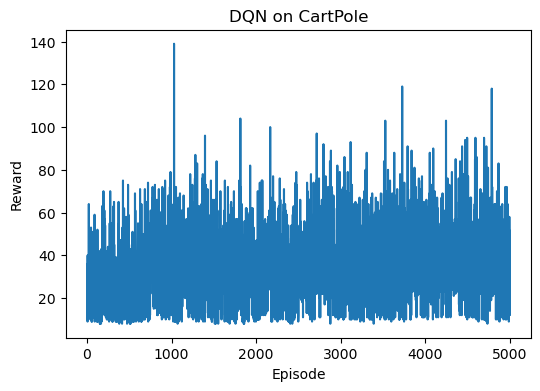

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('DQN on CartPole')
plt.show()

## 測試行動策略

In [18]:
def play_episodes(environment, n_episodes):
    wins = 0
    acc_reward = 0
    for episode in range(n_episodes):
        total_reward = 0
        done = False
        _, info = env.reset()
        state = get_screen(environment.render())
        while not done:
            # Select best action to perform in a current state
            action = select_action(state, epsilon)
            # Perform an action an observe how environment acted in response
            _, reward, terminated, truncated, info = environment.step(action)
            next_state = get_screen(env.render())
            done = terminated or truncated
            # Summarize total reward
            total_reward += reward
            acc_reward += reward
            # Update current state
            state = next_state
            # Calculate number of wins over episodes
            if done and total_reward >= 500:
                wins += 1
    average_reward = acc_reward / n_episodes
    return wins, acc_reward, average_reward

# 測試 100 回合
n_episodes = 100
wins, total_reward, average_reward = play_episodes(env, n_episodes)
print(f'number of wins over {n_episodes} episodes = {wins}')
print(f'average reward over {n_episodes} episodes = {average_reward} \n\n')

number of wins over 100 episodes = 0
average reward over 100 episodes = 29.41 


